In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import scipy.stats as stats
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

from hyperopt import hp, fmin, tpe, Trials

In [4]:
df = pd.read_csv('../data/day_ahead_energy_prices.csv', delimiter=",")
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

df.rename(columns={"hourly day-ahead energy price": "Price"}, inplace=True)

In [5]:
SPLIT_DATE = df.index[int(0.2 * len(df))]


train = df.loc[df.index < SPLIT_DATE]
test = df.loc[df.index >= SPLIT_DATE]

train.shape, test.shape

((67104, 1), (16777, 1))

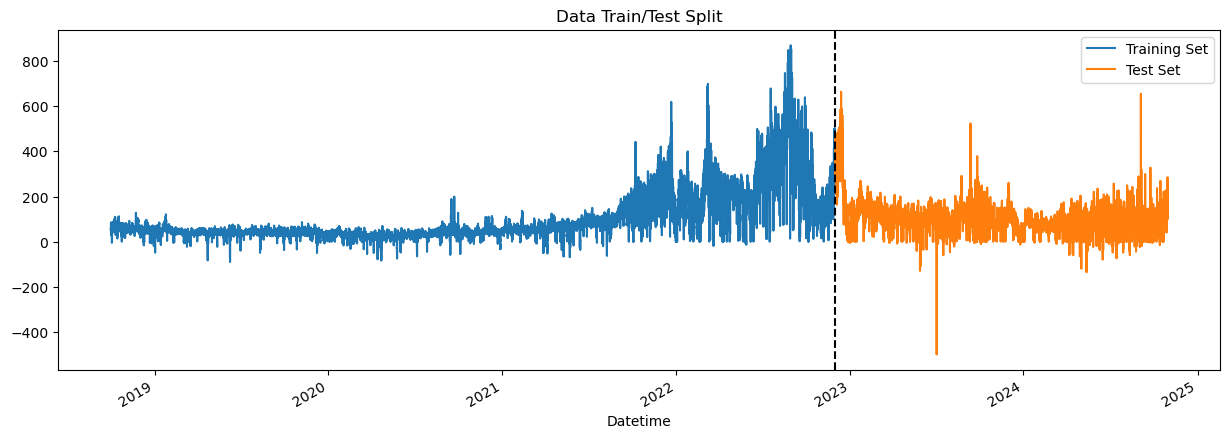

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline(SPLIT_DATE, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    for window in [3, 6, 12]: # hours
        df[f'ma_{int(window)}_hours'] = df['Price'].rolling(window=window).mean()
    
    for window in [24, 72, 168]:  # 1 day 3 days, and 1 week
        df[f'ma_{int(window / 24)}_days'] = df['Price'].rolling(window=window).mean()

    return df

df = create_features(df)
df

,Price,hour,dayofweek,dayofyear,weekofyear,ma_3_hours,ma_6_hours,ma_12_hours,ma_1_days,ma_3_days,ma_7_days
Datetime,,,,,,,,,,,
2024-10-29 22:00:00+00:00,103.09,22,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-29 21:00:00+00:00,118.08,21,1,303,44,NaN,NaN,NaN,NaN,NaN,NaN
2024-10-29 20:00:00+00:00,124.05,20,1,303,44,115.073333,NaN,NaN,NaN,NaN,NaN
2024-10-29 19:00:00+00:00,140.60,19,1,303,44,127.576667,NaN,NaN,NaN,NaN,NaN
2024-10-29 18:00:00+00:00,203.82,18,1,303,44,156.156667,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-10-01 02:00:00+00:00,47.59,2,0,274,40,56.110000,68.363333,65.673333,59.686667,40.311806,51.451071
2018-10-01 01:00:00+00:00,47.38,1,0,274,40,48.860000,63.000000,65.205000,59.837083,40.318750,51.451071
2018-10-01 00:00:00+00:00,51.41,0,0,274,40,48.793333,57.406667,64.807500,60.143333,40.399444,51.451071


In [8]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofyear', 'dayofweek', 'ma_3_hours','ma_6_hours','ma_1_days','ma_3_days','ma_7_days']
TARGET = 'Price'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

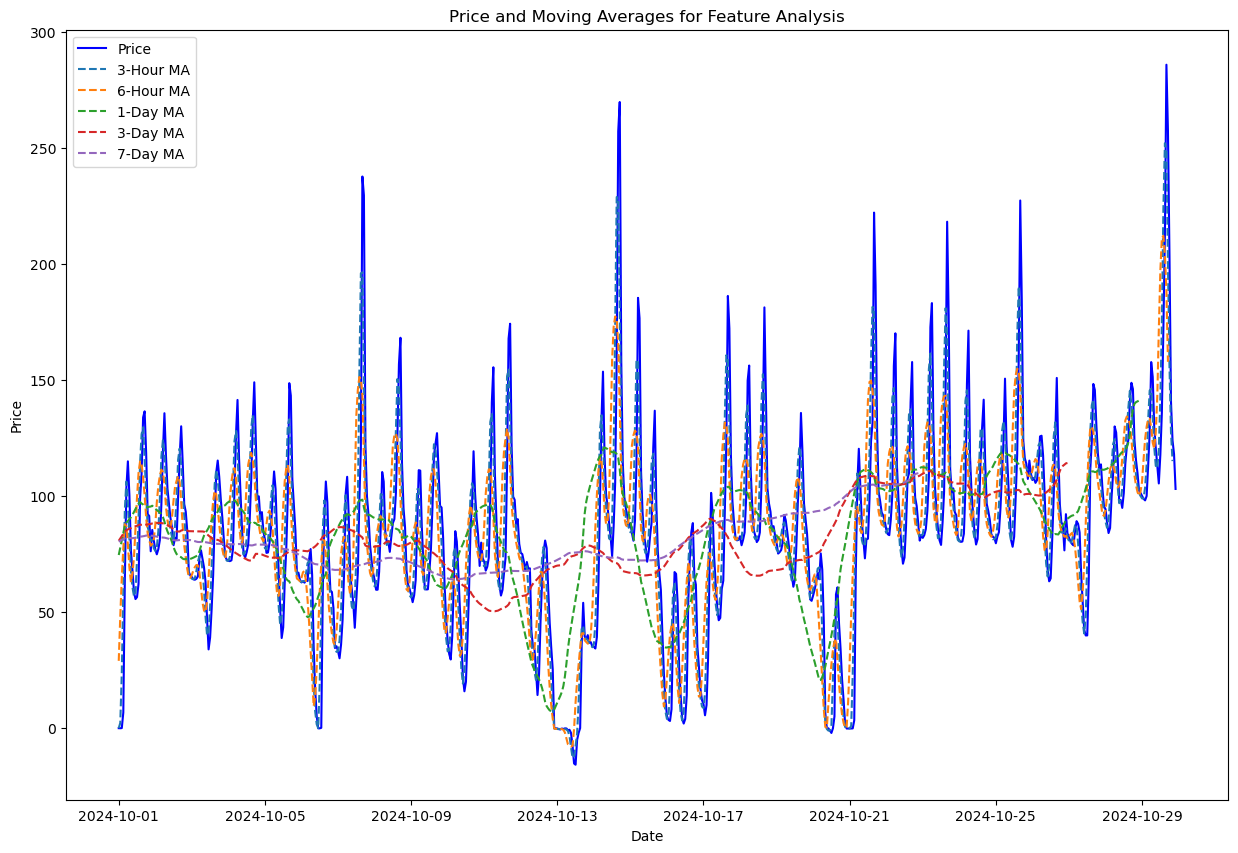

In [9]:
# Create features and assign to df_with_features
df_with_features = create_features(df)
df_with_features = df_with_features.sort_index()

# Visualize a specific period
visualization_df = df_with_features.loc['2024-10-01':'2024-10-31']

# Visualization
plt.figure(figsize=(15, 10))

# Original price data
plt.plot(visualization_df.index, visualization_df['Price'], label='Price', color='blue')

# Moving average features
plt.plot(visualization_df.index, visualization_df['ma_3_hours'], label='3-Hour MA', linestyle='--')
plt.plot(visualization_df.index, visualization_df['ma_6_hours'], label='6-Hour MA', linestyle='--')
plt.plot(visualization_df.index, visualization_df['ma_1_days'], label='1-Day MA', linestyle='--')
plt.plot(visualization_df.index, visualization_df['ma_3_days'], label='3-Day MA', linestyle='--')
plt.plot(visualization_df.index, visualization_df['ma_7_days'], label='7-Day MA', linestyle='--')

# Graph settings
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Price and Moving Averages for Feature Analysis')
plt.legend()
plt.show()


In [10]:
model = xgb.XGBRegressor()

In [11]:
# param_grid = {
#     "learning_rate": [0.01, 0.05, 0.15, 0.2, 0.3],
#     "base_score": [0.5, 0.6, 0.7,0.8,0.9,1],
#     "n_estimators": [100, 200, 300, 500, 750, 1000],
#     "early_stopping_rounds": [10, 25, 50, 75, 100],
#     "max_depth": [3,5,7,10]
#  }

# search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)


param_dist = {
    "learning_rate": stats.uniform(0.01, 0.3),  # Continuous, no need for int
    "base_score": stats.uniform(0.5, 0.5),      # Continuous, range 0.5 to 1
    "n_estimators": stats.randint(100, 1001),   # Integer range, 100 to 1000
    "early_stopping_rounds": stats.randint(10, 101),  # Integer range, 10 to 100
    "max_depth": stats.randint(3, 11)           # Integer range, 3 to 10
}

# run randomized search
# n_iter_search = 15
# search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=n_iter_search, cv=5, n_jobs=-1)
# search.fit(
#     X_train, y_train,
#     eval_set=[(X_test, y_test)], 
#     verbose=True,
# )

# print("Best parameters found: ", search.best_params_)

In [12]:
space = {
    'base_score': hp.uniform('base_score', 0.1, 0.9),
    'early_stopping_rounds': hp.choice('early_stopping_rounds', [10, 20, 30, 50, 70, 100]),
    'max_depth': hp.choice('max_depth', [2,3,4, 5, 7, 9, 11, 13, 15, 20, 25]),
    'learning_rate': hp.loguniform('learning_rate', -6.9, -1.2),  # 0.001 - 0.3 . e^{-6.9} ≈ 0.001, e^{-1.2} ≈ 0.3
    'n_estimators': hp.choice('n_estimators', [100, 300, 350, 400, 500, 1000, 10]),
    'gamma': hp.uniform('gamma', 0, 1),
    'min_child_weight': hp.choice('min_child_weight', [0.1, 1, 5, 10, 20]),
    'subsample': hp.uniform('subsample', 0.1, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1.0),
}

# Keeping track of the optimization history
trials = Trials()

def objective(params):

    model = xgb.XGBRegressor(
        base_score=params['base_score'],
        early_stopping_rounds=params['early_stopping_rounds'],
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        gamma=params['gamma'],
        min_child_weight=params['min_child_weight'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        objective='reg:squarederror',
    )
    
    # Fit the model on the training data
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],  # Provide validation set for early stopping
        verbose=False  # Suppress training output
    )
    
    # Predict on the validation set
    predictions = model.predict(X_test)
    
    # Calculate the root mean squared error (RMSE)
    rmse = root_mean_squared_error(y_test, predictions)
    
    return rmse

# Run the Hyperopt optimization
best = fmin(
    fn=objective,            # Objective function
    space=space,             # Hyperparameter space
    algo=tpe.suggest,        # Optimization algorithm
    max_evals=100,            # Number of trials
    trials=trials,           # Store trials history
)

# Display best parameters
print("Best hyperparameters:", best)

# Extract the best hyperparameters
best_params = {
    'base_score': best['base_score'],
    'early_stopping_rounds': best['early_stopping_rounds'],
    'max_depth': best['max_depth'],
    'learning_rate': best['learning_rate'],
    'n_estimators': best['n_estimators'],
    'colsample_bytree': best['colsample_bytree'],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'min_child_weight':best['min_child_weight'],
}

# Train the final model with the best hyperparameters on the full dataset
final_model = xgb.XGBRegressor(
    base_score=best_params['base_score'],
    early_stopping_rounds=best_params['early_stopping_rounds'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    gamma=best_params['gamma'],
    min_child_weight=best_params['min_child_weight'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    objective='reg:squarederror',
)

final_model.fit(X_train, y_train,  eval_set=[(X_test, y_test)])

# Predict on the test set or validation set
final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print("Final model RMSE:", final_rmse)


100%|██████████| 100/100 [05:06<00:00,  3.06s/trial, best loss: 12.41835825703363]
Best hyperparameters: {'base_score': 0.7901868069866845, 'colsample_bytree': 0.9254724280470972, 'early_stopping_rounds': 2, 'gamma': 0.8046806121558367, 'learning_rate': 0.014724388865037455, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 3, 'subsample': 0.599758697845703}
[0]	validation_0-rmse:110.91347
[1]	validation_0-rmse:109.31074
[2]	validation_0-rmse:107.73068
Final model RMSE: 107.73068065738599


autml gridsearch autoscikit-learn